<a href="https://colab.research.google.com/github/bu11ymaguire/Machin-Learning1/blob/main/HelloKorea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Google Drive 마운트 시
file_path = '/content/drive/MyDrive/koreaTrip.csv' # 실제 파일 경로로 변경
df = pd.read_csv(file_path)

In [4]:
# 필요한 라이브러리 설치 (Colab 기본 설치 외 추가 필요 시)
# Prophet은 종종 C++ 컴파일러 문제로 설치가 까다로울 수 있어, 오류 발생 시 개별적으로 설치하거나 버전 확인
!pip install prophet holidays # holidays는 Prophet의 휴일 기능에 필요
!pip install xgboost
!pip install lightgbm
!pip install statsmodels # SARIMAX 모델을 위해 필요

# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic') # 한글 폰트 설정 (Windows 사용자용)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 시계열 분석 및 모델링
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX # ARIMA/SARIMA 모델링용
from prophet import Prophet # Facebook Prophet

# 머신러닝 모델
from sklearn.model_selection import TimeSeriesSplit # 시계열 교차 검증용
from sklearn.preprocessing import MinMaxScaler, StandardScaler # 스케일링
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # 평가 지표
import xgboost as xgb
import lightgbm as lgb

# 경고 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')

print("필요 라이브러리 설치 및 임포트 완료.")

필요 라이브러리 설치 및 임포트 완료.


In [6]:
#Colab에서 한글 폰트 설정 예시 (필요시 실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [7]:
print("데이터프레임 첫 5행:")
print(df.head())
print("\n데이터프레임 정보:")
df.info()
print("\n결측치 확인:")
print(df.isnull().sum())

# 1. '시간(연도.월)' 컬럼 Datetime으로 변환 및 인덱스 설정
# 현재 Colab 스크린샷에서 컬럼명이 '시간(연도.월)'이 아닌 '시간(연도.월)'으로 보입니다.
# 실제 CSV 파일의 정확한 컬럼명을 확인하고 필요시 수정해주세요.
# 예시: 'Jan-15' 형식을 가정합니다.
df['시간(연도.월)'] = pd.to_datetime(df['시간(연도.월)'], format='%b-%y')
df.set_index('시간(연도.월)', inplace=True)

# 2. 모든 숫자 컬럼의 콤마 제거 및 float 타입 변환
# 데이터 로드 후 컬럼명에 따옴표가 있을 수 있으니 제거
df.columns = df.columns.str.replace('"', '').str.strip()

# 숫자형으로 변환할 컬럼 리스트 (CSV 파일의 실제 컬럼명에 맞춰 수정)
# '팬데믹' 컬럼은 0 또는 1로 구성된 정수형일 가능성이 높으므로 이 리스트에서 제외하거나 int로 처리
numerical_cols = [
    '관광수입(1K USD$)', '관광객수', '1인당 평균 지출(USD$)', '입국자 수',
    '항공편(인천국제공항_도착여객기)', '환율(USD-KRW)', '교통 인프라(지하철_연간)',
    '면세점_외국인 결제 데이터(단위수: 1M USD$)', '면세점_외국인_인원수(단위 수 천명)',
    '서부텍사스산_원유(WTI) (단위 수: 1 USD$)', '한국- 전국소비자 물가지수',
    '"한국"(구글트랜드_미국)', '"서울"(구글트랜드_미국)', '"KOREA"(구글트랜드_미국)',
    '"seoul"(구글트랜드_미국)', '"k-pop"(구글트랜드_미국)'
]

for col in numerical_cols:
    if col in df.columns: # 해당 컬럼이 데이터프레임에 존재하는지 확인
        # 콤마 제거 및 숫자로 변환 (에러 발생 시 NaN으로 처리)
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    else:
        print(f"경고: '{col}' 컬럼이 데이터프레임에 존재하지 않습니다. 컬럼명을 확인해주세요.")

# 3. 결측치 처리 (만약 있다면)
# 여기서는 선형 보간법을 예시로 사용합니다.
# 데이터의 특성상 다른 보간법 (ffill, bfill) 또는 도메인 지식 기반의 처리가 필요할 수 있습니다.
print("\n결측치 처리 전:")
print(df.isnull().sum())
df.interpolate(method='linear', inplace=True)
print("\n결측치 처리 후:")
print(df.isnull().sum())

# 4. 팬데믹 컬럼이 0/1 형태가 아니라면 적절히 변환 (예: 텍스트라면 0/1로 매핑)
# 현재 컬럼명이 '팬데믹'으로 보입니다. 데이터가 0과 1로 잘 되어 있는지 확인
if '팬데믹' in df.columns:
    df['팬데믹'] = df['팬데믹'].astype(int) # 정수형으로 변환하여 사용

print("\n전처리 후 데이터프레임 정보:")
df.info()
print("\n전처리 후 데이터프레임 첫 5행:")
print(df.head())

데이터프레임 첫 5행:
  시간(연도.월)       관광객수 1인당 평균 지출(USD$) 관광수입(1K USD$)    입국자 수  서울 평균 기온  \
0   Jan-15    723,255           1,014     1,230,500  917,054       3.6   
1   Feb-15    815,138            1066       1221300  1050706       6.0   
2   Mar-15    958,493            1202       1561500  1238144      12.4   
3   Apr-15  1,112,904            1241       1499600  1384567      18.8   
4   May-15  1,060,730            1088       1485500  1334212      24.9   

   부산 평균 기온  제주 평균 기온  서울(경기) 평균 강수일수  부산(경남) 평균 강수일수  ...  "여행 한국"(구글트랜드_태국)  \
0       9.4      10.2             7.0             8.9  ...                 81   
1      10.2      10.1             5.7             5.5  ...                 61   
2      14.3      13.6             3.7             5.8  ...                 68   
3      17.8      19.2            11.5            15.3  ...                 66   
4      22.9      22.7             5.8             7.9  ...                 62   

   "서울 한국"(구글트랜드_태국)  "한국 가기"(구글트랜드_태국)  환율(USD-KRW)  교

In [15]:
# 수정 전 (문제 발생):
# numerical_cols = [
#     ...,
#     '"한국"(구글트랜드_미국)', '"서울"(구글트랜드_미국)', '"KOREA"(구글트랜드_미국)',
#     '"seoul"(구글트랜드_미국)', '"k-pop"(구글트랜드_미국)'
# ]

# 수정 후 (올바름):
numerical_cols = [
    '관광수입(1K USD$)', '관광객수', '1인당 평균 지출(USD$)', '입국자 수',
    '항공편(인천국제공항_도착여객기)', '환율(USD-KRW)', '교통 인프라(지하철_연간)',
    '면세점_외국인 결제 데이터(단위수: 1M USD$)', '면세점_외국인_인원수(단위 수 천명)',
    '서부텍사스산_원유(WTI) (단위 수: 1 USD$)', '한국- 전국소비자 물가지수',
    '한국(구글트랜드_미국)', '서울(구글트랜드_미국)', '서울 여행(구글트랜드_미국)', # 이 부분도 출력된 컬럼명에 맞춰 수정
    '한국 여행(구글트랜드_미국)', 'k-pop(구글트랜드_미국)',
    '한국 여행(구글트랜드_일본)', '서울 관광(구글트랜드_일본)', '부산 여행(구글트랜드_일본)',
    '여행 한국(구글트랜드_태국)', '서울 한국(구글트랜드_태국)', '한국 가기(구글트랜드_태국)'
]

# 그리고 df['팬데믹'] = df['팬데믹'].astype(int) 부분은 이미 int64이므로 불필요하지만,
# 나중에 데이터가 다른 타입으로 로드될 경우를 대비해 두어도 좋습니다.

In [8]:
print("--- 특성 공학 시작 ---")

# 1. 시간 기반 특성 생성
# 인덱스가 DatetimeIndex이므로 바로 접근 가능
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['day_of_week'] = df.index.dayofweek # 요일 (0=월, 6=일)
df['day_of_year'] = df.index.dayofyear # 연중 몇 번째 날인지
df['week_of_year'] = df.index.isocalendar().week.astype(int) # 연중 몇 번째 주인지 (경고 방지 위해 .astype(int) 추가)


# 2. 지연 특성 (Lagged Features)
# 목표 변수(관광수입)의 과거 값은 미래 예측에 매우 중요합니다.
# 다른 주요 특성(관광객수, 환율 등)의 지연 특성도 유용할 수 있습니다.
df['관광수입_lag1'] = df['관광수입(1K USD$)'].shift(1) # 1개월 전 관광수입
df['관광수입_lag3'] = df['관광수입(1K USD$)'].shift(3) # 3개월 전 관광수입
df['관광수입_lag6'] = df['관광수입(1K USD$)'].shift(6) # 6개월 전 관광수입
df['관광수입_lag12'] = df['관광수입(1K USD$)'].shift(12) # 12개월 전 관광수입 (계절성 반영)

df['관광객수_lag1'] = df['관광객수'].shift(1) # 1개월 전 관광객수
df['환율_lag1'] = df['환율(USD-KRW)'].shift(1) # 1개월 전 환율


# 3. 이동 평균 특성 (Moving Average Features)
# 데이터의 단기적인 추세를 반영합니다.
df['관광수입_rolling_mean3'] = df['관광수입(1K USD$)'].rolling(window=3).mean() # 3개월 이동 평균
df['관광수입_rolling_mean6'] = df['관광수입(1K USD$)'].rolling(window=6).mean() # 6개월 이동 평균


# 4. 새로 생성된 NaN 값 처리
# shift나 rolling() 등으로 인해 생성된 초기 행의 NaN 값을 처리합니다.
# 일반적으로 시계열에서는 초기 몇 개의 행을 제거하는 것이 일반적입니다.
initial_nan_count = df.isnull().sum().sum()
if initial_nan_count > 0:
    print(f"\n새로운 특성 생성으로 인한 초기 NaN 값 개수: {initial_nan_count}")
    df.dropna(inplace=True)
    print("NaN 값 포함 행 제거 완료.")
else:
    print("\n새로운 특성 생성으로 인한 NaN 값 없음.")


print("\n--- 특성 공학 완료 ---")
print("특성 공학 후 데이터프레임 정보:")
df.info()
print("\n특성 공학 후 데이터프레임 첫 5행:")
print(df.head())
print("\n특성 공학 후 데이터프레임 마지막 5행 (미래 데이터 생성 확인):")
print(df.tail())

--- 특성 공학 시작 ---

새로운 특성 생성으로 인한 초기 NaN 값 개수: 31
NaN 값 포함 행 제거 완료.

--- 특성 공학 완료 ---
특성 공학 후 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2016-01-01 to 2024-12-01
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   관광객수                           108 non-null    int64  
 1   1인당 평균 지출(USD$)                108 non-null    int64  
 2   관광수입(1K USD$)                  108 non-null    int64  
 3   입국자 수                          108 non-null    int64  
 4   서울 평균 기온                       108 non-null    float64
 5   부산 평균 기온                       108 non-null    float64
 6   제주 평균 기온                       108 non-null    float64
 7   서울(경기) 평균 강수일수                 108 non-null    float64
 8   부산(경남) 평균 강수일수                 108 non-null    float64
 9   제주 평균 강수일수                     108 non-null    float64
 10  공휴일                            108 non-null    

In [9]:
print("--- 데이터 분할 시작 ---")

# 목표 변수(Target Variable) 설정
# '관광수입(1K USD$)'을 예측 목표로 설정합니다.
target_col = '관광수입(1K USD$)'
features = [col for col in df.columns if col != target_col]

X = df[features]
y = df[target_col]

# 데이터 분할 전략 설정
# 시계열 데이터이므로 시간 순서에 따라 분할합니다.
# 마지막 12개월 (1년)을 테스트 세트로, 그 이전 12개월 (1년)을 검증 세트로, 나머지를 학습 세트로 분할합니다.
# 데이터가 총 108개월이므로:
# 테스트 세트: 마지막 12개월 (108 - 12 = 96부터 끝까지)
# 검증 세트: 그 이전 12개월 (96 - 12 = 84부터 96까지)
# 학습 세트: 나머지 (0부터 84까지)

test_size = 12 # 12개월
val_size = 12  # 12개월

train_end_index = len(df) - test_size - val_size # 108 - 12 - 12 = 84
val_end_index = len(df) - test_size             # 108 - 12 = 96

X_train = X.iloc[:train_end_index]
y_train = y.iloc[:train_end_index]

X_val = X.iloc[train_end_index:val_end_index]
y_val = y.iloc[train_end_index:val_end_index]

X_test = X.iloc[val_end_index:]
y_test = y.iloc[val_end_index:]

print(f"총 데이터 기간: {df.index.min().strftime('%Y-%m')} ~ {df.index.max().strftime('%Y-%m')}")
print(f"학습 세트 기간: {X_train.index.min().strftime('%Y-%m')} ~ {X_train.index.max().strftime('%Y-%m')} (기간: {len(X_train)}개월)")
print(f"검증 세트 기간: {X_val.index.min().strftime('%Y-%m')} ~ {X_val.index.max().strftime('%Y-%m')} (기간: {len(X_val)}개월)")
print(f"테스트 세트 기간: {X_test.index.min().strftime('%Y-%m')} ~ {X_test.index.max().strftime('%Y-%m')} (기간: {len(X_test)}개월)")

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\n--- 데이터 분할 완료 ---")

--- 데이터 분할 시작 ---
총 데이터 기간: 2016-01 ~ 2024-12
학습 세트 기간: 2016-01 ~ 2022-12 (기간: 84개월)
검증 세트 기간: 2023-01 ~ 2023-12 (기간: 12개월)
테스트 세트 기간: 2024-01 ~ 2024-12 (기간: 12개월)

X_train shape: (84, 43), y_train shape: (84,)
X_val shape: (12, 43), y_val shape: (12,)
X_test shape: (12, 43), y_test shape: (12,)

--- 데이터 분할 완료 ---


--- SARIMAX 모델 학습 및 평가 시작 ---
SARIMAX 모델 요약:
                                     SARIMAX Results                                      
Dep. Variable:                      관광수입(1K USD$)   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -719.287
Date:                            Sun, 25 May 2025   AIC                           1534.574
Time:                                    14:52:45   BIC                           1632.641
Sample:                                01-01-2016   HQIC                          1572.686
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
관광객수                           

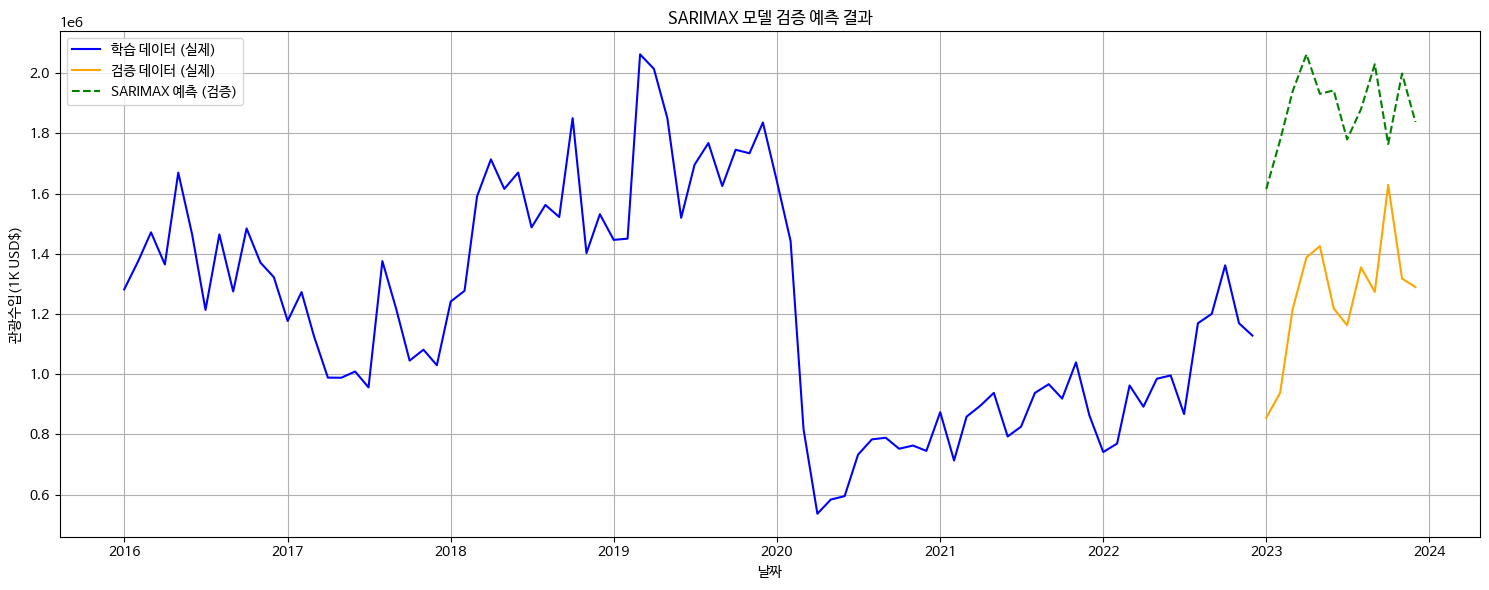

--- SARIMAX 모델 학습 및 평가 완료 ---


In [10]:
print("--- SARIMAX 모델 학습 및 평가 시작 ---")

# 필요한 라이브러리 임포트 (앞서 전체 임포트에서 포함되었을 것이므로 재실행 불필요할 수 있으나, 안전을 위해 다시 명시)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # y_train, X_train 등이 DataFrame/Series이므로 필요

# SARIMAX 모델 학습
# order = (p, d, q) : 비계절성 차수
# seasonal_order = (P, D, Q, S) : 계절성 차수 (S=12는 월별 데이터의 연간 계절성)
# 이 차수들은 데이터의 ACF/PACF 플롯 분석을 통해 결정하는 것이 가장 좋습니다.
# 여기서는 일반적인 시계열 데이터에서 시도해볼 만한 예시 차수를 사용합니다.
# 모델이 수렴하지 않거나 성능이 좋지 않다면 이 차수를 조정해야 합니다.
sarimax_model = SARIMAX(y_train,
                        exog=X_train, # 외부 변수 사용
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, # 비정상성 데이터를 허용할지 여부
                        enforce_invertibility=False) # 가역성을 강제할지 여부

# 모델 피팅 (수렴 문제가 발생할 경우 maxiter를 늘리거나 disp=False로 상세 메시지 숨김)
try:
    sarimax_results = sarimax_model.fit(disp=False, maxiter=100) # maxiter를 100으로 늘려 수렴 시도
    print("SARIMAX 모델 요약:")
    print(sarimax_results.summary())
except Exception as e:
    print(f"SARIMAX 모델 학습 중 오류 발생: {e}")
    print("차수 (order, seasonal_order)를 조정하거나 데이터를 확인해 보세요.")
    sarimax_results = None # 오류 발생 시 results 객체가 생성되지 않도록 함

if sarimax_results:
    # 검증 세트 예측
    # start와 end는 DatetimeIndex 값을 직접 사용합니다.
    # exog는 예측 기간에 해당하는 X_val 데이터를 전달해야 합니다.
    sarimax_val_preds = sarimax_results.predict(start=X_val.index[0], end=X_val.index[-1], exog=X_val)

    # 평가 지표 계산
    mae_sarimax_val = mean_absolute_error(y_val, sarimax_val_preds)
    rmse_sarimax_val = np.sqrt(mean_squared_error(y_val, sarimax_val_preds))
    r2_sarimax_val = r2_score(y_val, sarimax_val_preds)

    print(f"\nSARIMAX 검증 MAE: {mae_sarimax_val:.2f}")
    print(f"SARIMAX 검증 RMSE: {rmse_sarimax_val:.2f}")
    print(f"SARIMAX 검증 R2: {r2_sarimax_val:.2f}")

    # 예측 결과 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
    plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
    plt.plot(sarimax_val_preds.index, sarimax_val_preds, label='SARIMAX 예측 (검증)', color='green', linestyle='--')
    plt.title('SARIMAX 모델 검증 예측 결과')
    plt.xlabel('날짜')
    plt.ylabel('관광수입(1K USD$)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("--- SARIMAX 모델 학습 및 평가 완료 ---")

--- Prophet 모델 학습 및 평가 시작 ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mw9dtbe/ao9is4zw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mw9dtbe/q2az1jv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19411', 'data', 'file=/tmp/tmp_mw9dtbe/ao9is4zw.json', 'init=/tmp/tmp_mw9dtbe/q2az1jv2.json', 'output', 'file=/tmp/tmp_mw9dtbe/prophet_modelheb_y3yc/prophet_model-20250525145357.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet 검증 MAE: 433657.81
Prophet 검증 RMSE: 448323.68
Prophet 검증 R2: -4.10


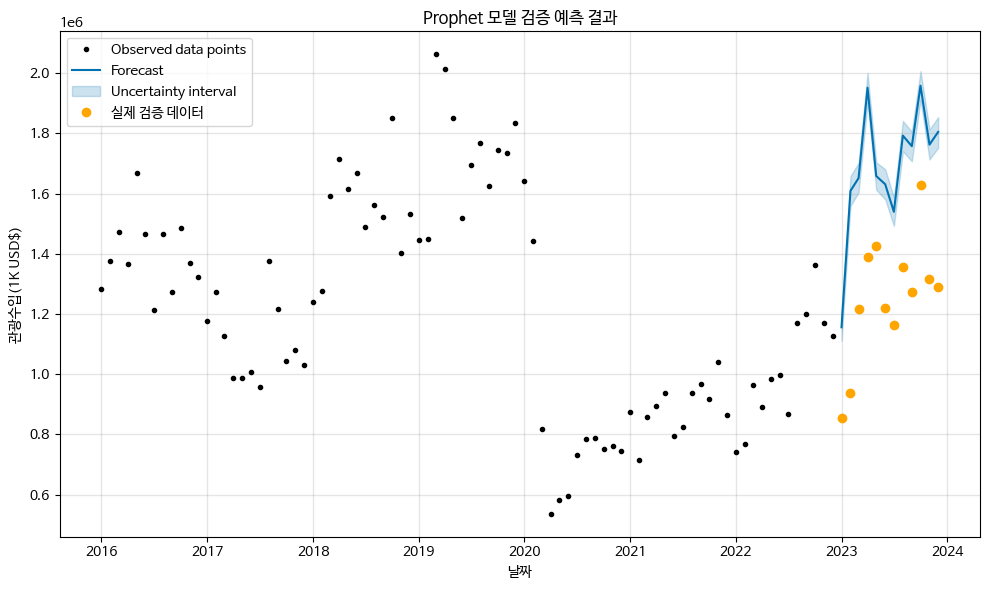

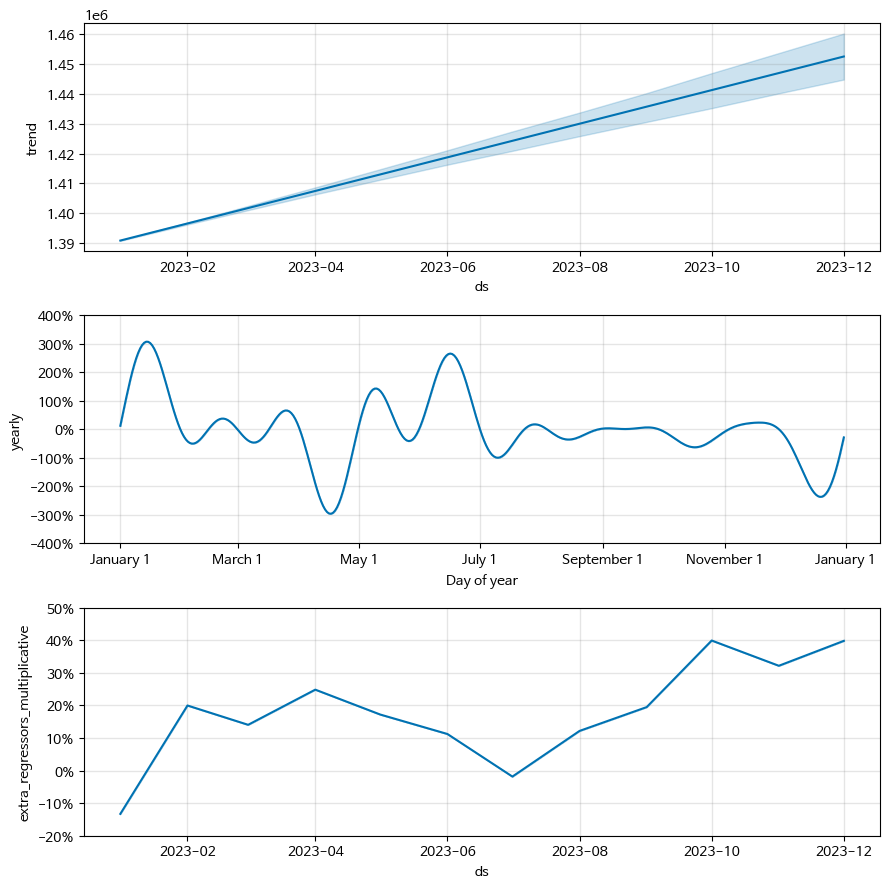

--- Prophet 모델 학습 및 평가 완료 ---


In [11]:
print("--- Prophet 모델 학습 및 평가 시작 ---")

# 필요한 라이브러리 임포트
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # y_train, X_train 등이 DataFrame/Series이므로 필요

# Prophet은 입력 데이터프레임이 'ds'(날짜)와 'y'(목표 변수) 컬럼을 가져야 합니다.
# 또한, 외부 변수는 'add_regressor'로 추가해야 합니다.

# Prophet용 데이터프레임 준비
# df는 이미 DatetimeIndex를 가지고 있으므로 reset_index()를 사용
prophet_df = df.reset_index().rename(columns={'시간(연도.월)': 'ds', '관광수입(1K USD$)': 'y'})

# 학습, 검증 데이터 분할 (Prophet용 데이터프레임 기준으로 인덱싱)
# y_train, y_val의 길이를 기준으로 분할
prophet_train_df = prophet_df.iloc[:len(y_train)].copy() # .copy()를 추가하여 SettingWithCopyWarning 방지
prophet_val_df = prophet_df.iloc[len(y_train):len(y_train) + len(y_val)].copy()

# Prophet 모델 생성 및 설정
m = Prophet(
    growth='linear', # 추세 모델: 'linear' (선형) 또는 'logistic' (성장 한계가 있는 경우)
    seasonality_mode='multiplicative', # 계절성 모델: 'additive' (덧셈) 또는 'multiplicative' (곱셈)
    daily_seasonality=False, # 일별 계절성 (우리는 월별 데이터이므로 False)
    weekly_seasonality=False, # 주별 계절성 (우리는 월별 데이터이므로 False)
    yearly_seasonality=True # 연간 계절성 (월별 데이터에서 중요)
    # interval_width=0.95 # 예측 구간의 폭 설정 (선택 사항)
)

# 외부 변수 추가 (목표 변수 제외 및 Prophet이 자체적으로 처리하는 시간 기반 특성 제외)
# X_train.columns에는 우리가 생성한 year, month 등이 포함되어 있으므로, 이를 제외하고 add_regressor에 추가
prophet_regressors = [col for col in X_train.columns if col not in ['year', 'month', 'quarter', 'day_of_week', 'day_of_year', 'week_of_year']]

for feature in prophet_regressors:
    m.add_regressor(feature)

# 모델 학습
m.fit(prophet_train_df)

# 예측을 위한 미래 데이터프레임 생성
# X_val에 해당하는 날짜와 특성들을 포함해야 합니다.
# prophet_df에서 검증 세트에 해당하는 ds와 regressor 특성들만 추출
future = prophet_df[['ds'] + prophet_regressors].iloc[len(y_train):len(y_train) + len(y_val)]

# 예측 수행
prophet_val_preds_df = m.predict(future)
prophet_val_preds = prophet_val_preds_df['yhat']

# 평가 지표 계산
mae_prophet_val = mean_absolute_error(y_val, prophet_val_preds)
rmse_prophet_val = np.sqrt(mean_squared_error(y_val, prophet_val_preds))
r2_prophet_val = r2_score(y_val, prophet_val_preds)

print(f"\nProphet 검증 MAE: {mae_prophet_val:.2f}")
print(f"Prophet 검증 RMSE: {rmse_prophet_val:.2f}")
print(f"Prophet 검증 R2: {r2_prophet_val:.2f}")

# 예측 결과 시각화
fig = m.plot(prophet_val_preds_df) # Prophet의 기본 예측 플롯
plt.plot(prophet_val_df['ds'], prophet_val_df['y'], 'o', color='orange', label='실제 검증 데이터') # 실제 검증 데이터 추가
plt.title('Prophet 모델 검증 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend() # 범례 추가
plt.grid(True)
plt.tight_layout()
plt.show()

# 컴포넌트 시각화 (추세, 계절성, 회귀변수 효과 등)
fig_components = m.plot_components(prophet_val_preds_df)
plt.tight_layout()
plt.show()

print("--- Prophet 모델 학습 및 평가 완료 ---")

--- XGBoost 모델 학습 및 평가 시작 ---

XGBoost 검증 MAE: 105066.04
XGBoost 검증 RMSE: 134864.77
XGBoost 검증 R2: 0.54


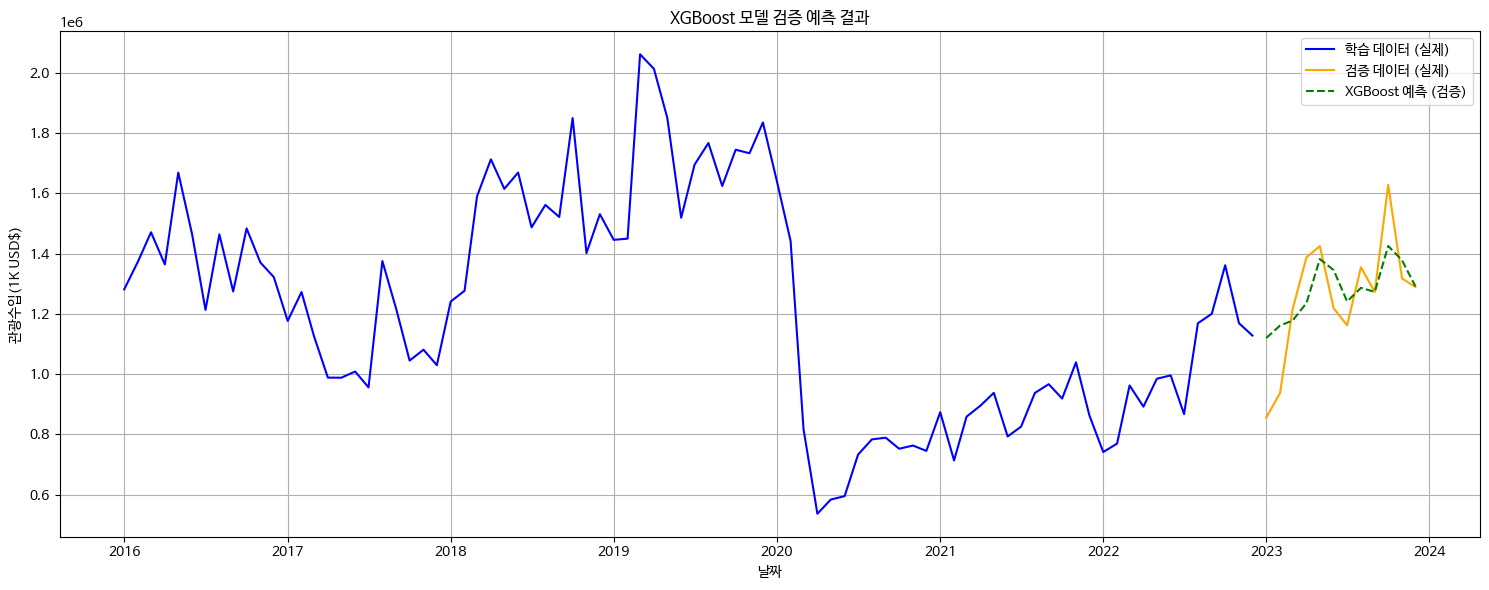

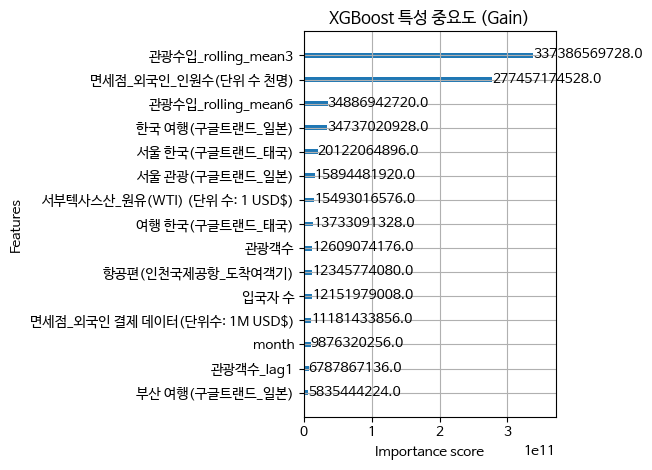

--- XGBoost 모델 학습 및 평가 완료 ---


In [14]:
print("--- XGBoost 모델 학습 및 평가 시작 ---")

# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',     # 회귀 문제
    n_estimators=1000,                # 트리의 개수 (충분히 큰 값으로 설정하고 조기 종료 사용)
    learning_rate=0.05,               # 학습률
    max_depth=5,                      # 각 트리의 최대 깊이
    subsample=0.8,                    # 각 트리 학습에 사용할 샘플 비율
    colsample_bytree=0.8,             # 각 트리 학습에 사용할 특성(컬럼)의 비율
    random_state=42,                  # 재현성을 위한 시드
    n_jobs=-1,                        # 모든 코어 사용

    # ! 최신 XGBoost 버전에서 변경된 부분 !
    # early_stopping_rounds와 eval_metric을 생성자 인자로 전달합니다.
    early_stopping_rounds=50,         # 50번의 반복 동안 성능 개선이 없으면 중단
    eval_metric='rmse'                # 검증 시 사용할 평가 지표 (회귀에서는 'rmse' 또는 'mae' 추천)
)

# 모델 피팅 (eval_set은 여전히 필요하지만, early_stopping_rounds와 eval_metric은 이미 모델에 설정됨)
# verbose=False로 학습 과정 메시지 비활성화
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              verbose=False)             # 학습 과정 메시지 비활성화

# 검증 세트 예측
xgb_val_preds = xgb_model.predict(X_val)

# 평가 지표 계산
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)

print(f"\nXGBoost 검증 MAE: {mae_xgb_val:.2f}")
print(f"XGBoost 검증 RMSE: {rmse_xgb_val:.2f}")
print(f"XGBoost 검증 R2: {r2_xgb_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.title('XGBoost 모델 검증 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화 (선택 사항)
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15, title='XGBoost 특성 중요도 (Gain)')
plt.tight_layout()
plt.show()

print("--- XGBoost 모델 학습 및 평가 완료 ---")

--- LightGBM 모델 학습 및 평가 시작 ---
컬럼명 정리 후 X_train 컬럼 목록:
['관광객수', '1인당_평균_지출USD', '입국자_수', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', '항공편인천국제공항_도착여객기', '한국구글트랜드_미국', '서울구글트랜드_미국', '서울_여행구글트랜드_미국', '한국_여행구글트랜드_미국', 'kpop구글트랜드_미국', '한국_여행구글트랜드_일본', '서울_관광구글트랜드_일본', '부산_여행구글트랜드_일본', '여행_한국구글트랜드_태국', '서울_한국구글트랜드_태국', '한국_가기구글트랜드_태국', '환율USDKRW', '교통_인프라지하철_연간', '면세점_외국인_결제_데이터단위수_1M_USD', '면세점_외국인_인원수단위_수_천명', '서부텍사스산_원유WTI_단위_수_1_USD', '팬데믹', '한국_전국소비자_물가지수', 'year', 'month', 'quarter', 'day_of_week', 'day_of_year', 'week_of_year', '관광수입_lag1', '관광수입_lag3', '관광수입_lag6', '관광수입_lag12', '관광객수_lag1', '환율_lag1', '관광수입_rolling_mean3', '관광수입_rolling_mean6']
--------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train 

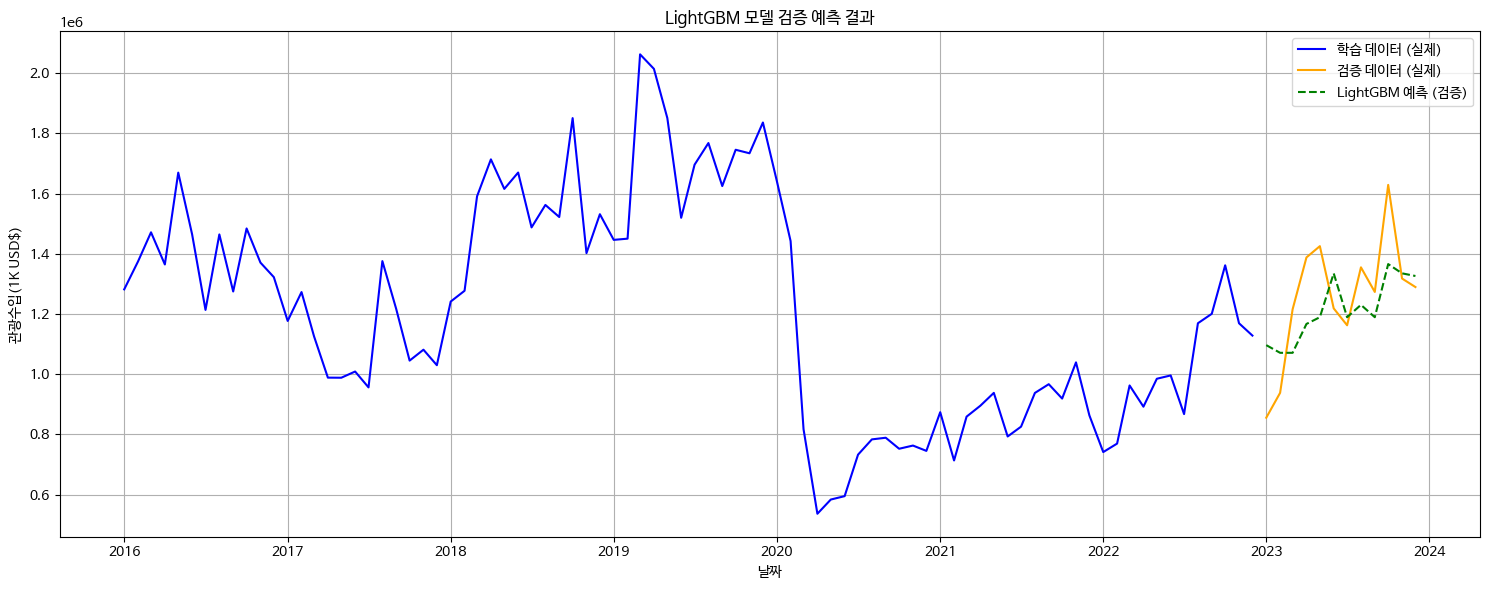

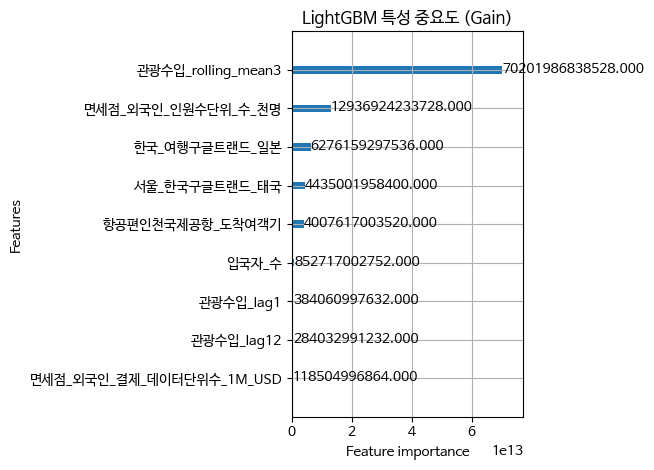

--- LightGBM 모델 학습 및 평가 완료 ---


In [17]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # 정규표현식(regular expression) 라이브러리 임포트

print("--- LightGBM 모델 학습 및 평가 시작 ---")

# --- LightGBM 오류 해결을 위한 컬럼명 정리 ---
# 모든 특수문자를 제거하고, 공백은 언더스코어로 대체하는 더욱 강력한 버전
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        # 공백을 언더스코어로 대체
        new_col = col.replace(' ', '_')
        # 한글, 영어 대소문자, 숫자, 언더스코어만 남기고 모두 제거
        # re.sub(패턴, 대체문자, 원본문자열)
        new_col = re.sub(r'[^\w가-힣_]', '', new_col) # \w는 [a-zA-Z0-9_]와 동일
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# X_train, X_val, X_test에 컬럼명 정리 함수 적용
# 이전 실행에서 이미 df_original에서 분할된 X_train, X_val, X_test가 메모리에 있으므로,
# 그 변수들을 직접 수정해야 합니다.
# (이전 코드에서 .copy()를 사용했으므로, 다시 로드할 필요 없이 현재 X_train, X_val, X_test에 적용)

# 중요: 이전에 df 전체에 적용했던 clean_col_names는 DatetimeIndex 컬럼에 대한 처리 방식과
# 전체적인 데이터프레임의 구조에 따라 다르게 작동할 수 있습니다.
# 현재 문제는 X_train, X_val, X_test의 컬럼명에 있는 것이므로, 이들에 직접 적용합니다.

# 현재 환경에 정의된 X_train, X_val, X_test 변수에 직접 적용
X_train = clean_col_names(X_train)
X_val = clean_col_names(X_val)
X_test = clean_col_names(X_test)


print("컬럼명 정리 후 X_train 컬럼 목록:")
print(X_train.columns.tolist())
print("-" * 50)


# LightGBM 모델 학습
lgb_model = lgb.LGBMRegressor(
    objective='regression', # 회귀 문제에 사용
    n_estimators=1000,      # 부스팅 트리의 개수
    learning_rate=0.05,     # 학습률
    num_leaves=31,          # 트리의 최대 잎 노드 수 (기본값)
    max_depth=-1,           # 트리의 최대 깊이 (-1은 제한 없음, num_leaves에 따라 자동 조절)
    reg_alpha=0.1,          # L1 정규화 (과적합 방지)
    reg_lambda=0.1,         # L2 정규화 (과적합 방지)
    random_state=42,        # 결과 재현성을 위한 시드
    n_jobs=-1               # 모든 CPU 코어 사용
)

# 조기 종료 (early stopping)
lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              eval_metric='mae', # 검증 시 사용할 평가 지표 (mse, rmse, mae 등)
              callbacks=[lgb.early_stopping(50, verbose=False)]) # 50번의 반복 동안 성능 개선 없으면 중단

# 검증 세트 예측
lgb_val_preds = lgb_model.predict(X_val)

# 평가 지표 계산
mae_lgb_val = mean_absolute_error(y_val, lgb_val_preds)
rmse_lgb_val = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
r2_lgb_val = r2_score(y_val, lgb_val_preds)

print(f"\nLightGBM 검증 MAE: {mae_lgb_val:.2f}")
print(f"LightGBM 검증 RMSE: {rmse_lgb_val:.2f}")
print(f"LightGBM 검증 R2: {r2_lgb_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(X_val.index, lgb_val_preds, label='LightGBM 예측 (검증)', color='green', linestyle='--')
plt.title('LightGBM 모델 검증 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화 (선택 사항)
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=15, title='LightGBM 특성 중요도 (Gain)')
plt.tight_layout()
plt.show()

print("--- LightGBM 모델 학습 및 평가 완료 ---")

--- XGBoost 모델 재학습 및 평가 시작 (정리된 컬럼명 사용) ---
XGBoost 학습 전, 정리된 X_train 컬럼 목록:
['관광객수', '1인당_평균_지출USD', '입국자_수', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', '항공편인천국제공항_도착여객기', '한국구글트랜드_미국', '서울구글트랜드_미국', '서울_여행구글트랜드_미국', '한국_여행구글트랜드_미국', 'kpop구글트랜드_미국', '한국_여행구글트랜드_일본', '서울_관광구글트랜드_일본', '부산_여행구글트랜드_일본', '여행_한국구글트랜드_태국', '서울_한국구글트랜드_태국', '한국_가기구글트랜드_태국', '환율USDKRW', '교통_인프라지하철_연간', '면세점_외국인_결제_데이터단위수_1M_USD', '면세점_외국인_인원수단위_수_천명', '서부텍사스산_원유WTI_단위_수_1_USD', '팬데믹', '한국_전국소비자_물가지수', 'year', 'month', 'quarter', 'day_of_week', 'day_of_year', 'week_of_year', '관광수입_lag1', '관광수입_lag3', '관광수입_lag6', '관광수입_lag12', '관광객수_lag1', '환율_lag1', '관광수입_rolling_mean3', '관광수입_rolling_mean6']
--------------------------------------------------

XGBoost 검증 MAE (정리된 컬럼명): 105066.04
XGBoost 검증 RMSE (정리된 컬럼명): 134864.77
XGBoost 검증 R2 (정리된 컬럼명): 0.54


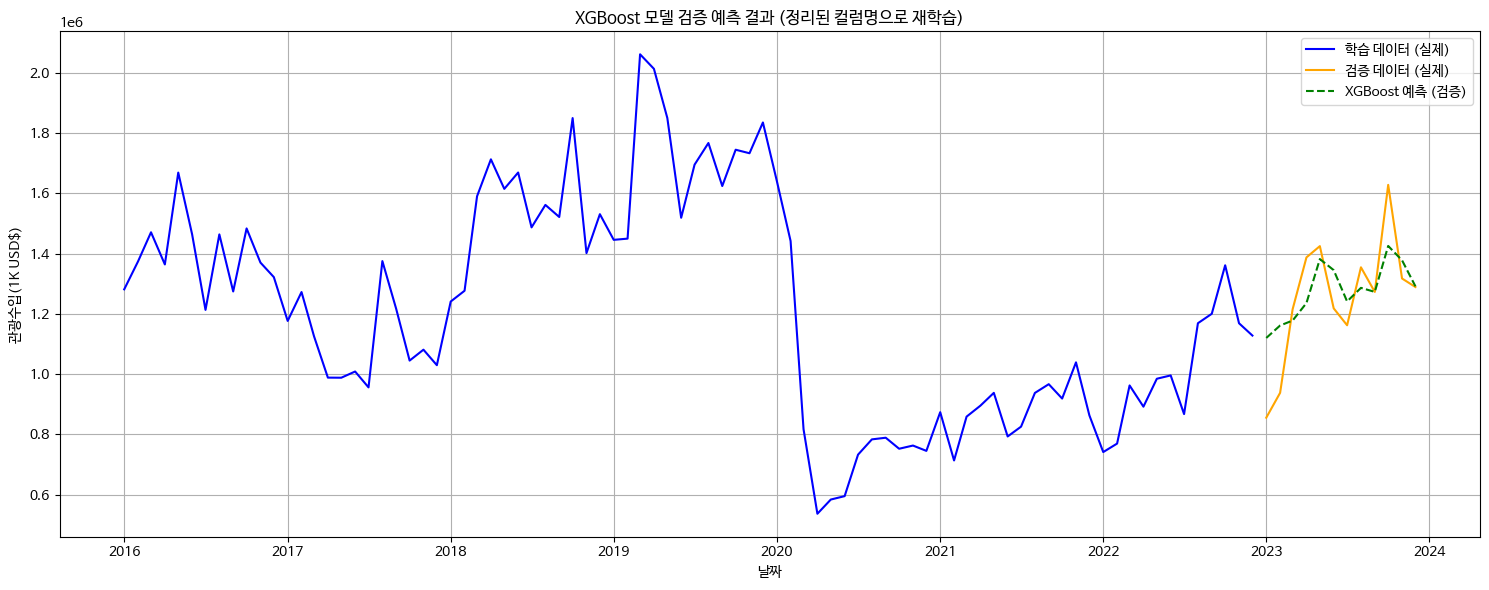

--- XGBoost 모델 재학습 및 평가 완료 ---


In [19]:
print("--- XGBoost 모델 재학습 및 평가 시작 (정리된 컬럼명 사용) ---")

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # 정규표현식(regular expression) 라이브러리 임포트

# --- 컬럼명 정리 함수 (LightGBM 오류 해결 시 사용했던 함수) ---
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w가-힣_]', '', new_col) # 모든 특수문자 제거
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# 중요: 이전에 원본 df에서 X_train, X_val, X_test를 분할했습니다.
# LightGBM 학습 전에 X_train, X_val, X_test의 컬럼명을 수정했으므로,
# 현재 메모리에 있는 X_train, X_val, X_test 변수들을 직접 수정하여 사용합니다.
# 만약 이 셀만 단독으로 실행한다면, X_train, X_val, X_test가 정의되지 않았을 수 있으므로
# 데이터 로드부터 분할까지의 전체 과정을 다시 실행하여 변수들이 올바르게 정의되어 있는지 확인해야 합니다.
# (대부분의 경우, Colab 세션이 유지되는 동안에는 변수들이 남아있습니다.)

# X_train, X_val에 컬럼명 정리 함수 적용 (X_test도 추후를 위해 정리)
X_train = clean_col_names(X_train)
X_val = clean_col_names(X_val)
X_test = clean_col_names(X_test) # 테스트 세트도 미리 정리해둡니다.

print("XGBoost 학습 전, 정리된 X_train 컬럼 목록:")
print(X_train.columns.tolist())
print("-" * 50)


# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',     # 회귀 문제
    n_estimators=1000,                # 트리의 개수
    learning_rate=0.05,               # 학습률
    max_depth=5,                      # 각 트리의 최대 깊이
    subsample=0.8,                    # 각 트리 학습에 사용할 샘플 비율
    colsample_bytree=0.8,             # 각 트리 학습에 사용할 특성(컬럼)의 비율
    random_state=42,                  # 재현성을 위한 시드
    n_jobs=-1,                        # 모든 코어 사용
    early_stopping_rounds=50,         # 50번의 반복 동안 성능 개선이 없으면 중단
    eval_metric='rmse'                # 검증 시 사용할 평가 지표
)

# 모델 피팅
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              verbose=False)             # 학습 과정 메시지 비활성화

# 검증 세트 예측 (재확인)
xgb_val_preds = xgb_model.predict(X_val)

# 평가 지표 계산 (재확인)
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)

print(f"\nXGBoost 검증 MAE (정리된 컬럼명): {mae_xgb_val:.2f}")
print(f"XGBoost 검증 RMSE (정리된 컬럼명): {rmse_xgb_val:.2f}")
print(f"XGBoost 검증 R2 (정리된 컬럼명): {r2_xgb_val:.2f}")

# 예측 결과 시각화 (재확인)
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.title('XGBoost 모델 검증 예측 결과 (정리된 컬럼명으로 재학습)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- XGBoost 모델 재학습 및 평가 완료 ---")

--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 시작 ---

최종 XGBoost 모델 테스트 MAE: 102866.50
최종 XGBoost 모델 테스트 RMSE: 138744.69
최종 XGBoost 모델 테스트 R2: 0.54


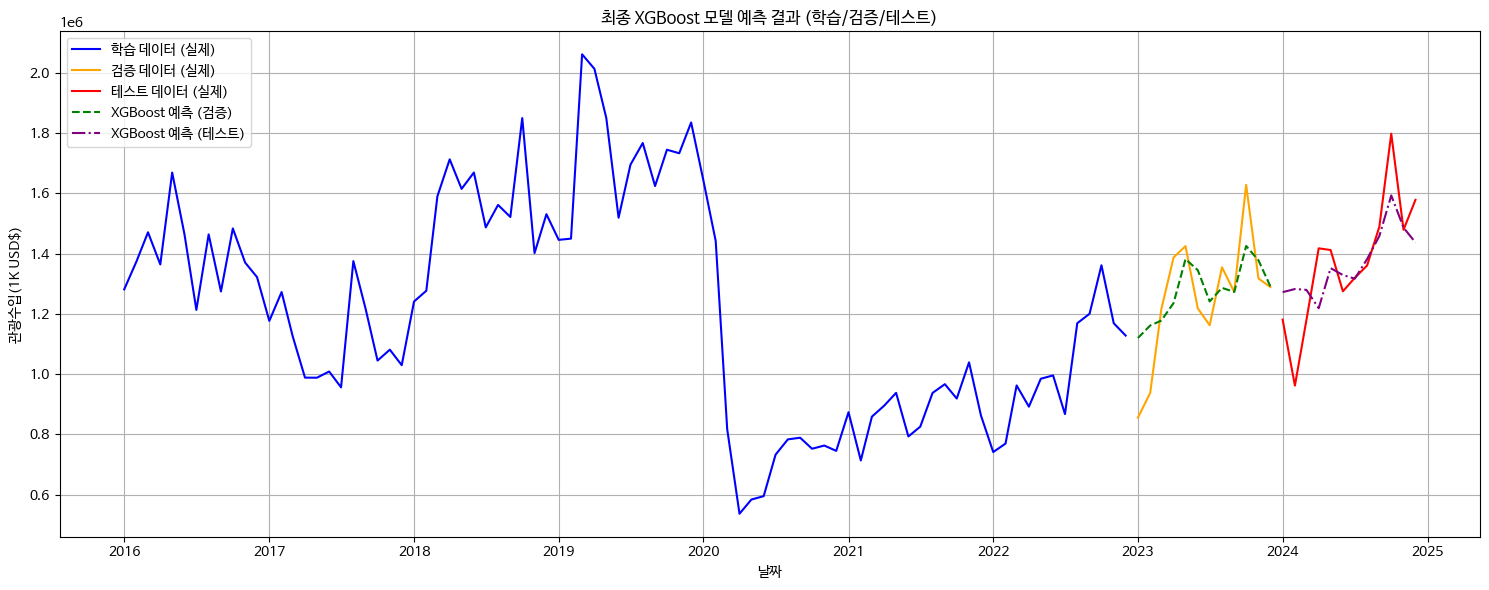

--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 완료 ---


In [20]:
print("--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 시작 ---")

# 현재 메모리에 있는 xgb_model은 컬럼명이 정리된 데이터로 재학습된 모델입니다.
# 이제 X_test도 컬럼명이 정리되었으므로 일치합니다.

# 테스트 세트 예측
xgb_test_preds = xgb_model.predict(X_test)

# 평가 지표 계산
mae_xgb_test = mean_absolute_error(y_test, xgb_test_preds)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
r2_xgb_test = r2_score(y_test, xgb_test_preds)

print(f"\n최종 XGBoost 모델 테스트 MAE: {mae_xgb_test:.2f}")
print(f"최종 XGBoost 모델 테스트 RMSE: {rmse_xgb_test:.2f}")
print(f"최종 XGBoost 모델 테스트 R2: {r2_xgb_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(y_test.index, y_test, label='테스트 데이터 (실제)', color='red') # 테스트 실제 데이터 추가
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--') # 검증 예측도 함께 표시
plt.plot(X_test.index, xgb_test_preds, label='XGBoost 예측 (테스트)', color='purple', linestyle='-.') # 테스트 예측 표시
plt.title('최종 XGBoost 모델 예측 결과 (학습/검증/테스트)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 완료 ---")